<br/><u><font size=8 color='darkgreen'>Binary Classification</font></u>

# <font color='navy'><u>Problem Statement</u></font>

An Internet Service Provider company has data of its customers. The company wants to predict the customers who are more likely to churn <font color='grey'>(cancelling their subscriptions)</font> based on the historical data. So that they can take some remedial measures such as taking their feedback, improving their experience and rolling out more offers & discounts to retain the customers.

Here we are going to use the <b>Logistic Regression</b> algorithm with <b>Binary Cross-Entropy Loss</b> function to optimize the model. Our aim is as follows.
 - Determine the predictor variables that affect the churn 
 - Determine the significance of each variable in the prediction
 - Obtain the probabilities for all data points using the logistic regression model
 - Choose the most important performance metric relevant to this specific business problem
 - Choose an appropriate probability threshold to make the final classficiation and improve the above metric

# <font color='navy'><u>Exploratory Data Analysis</u></font>

In [1]:
#importing libraries to perform EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the data csv and converting it into a dataframe
df=pd.read_csv('internet_service_churn.csv')

# quick peek into the dataframe
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   remaining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


Clearly there are some columns having <b>null</b>s. So we have to treat them using <b>imputation</b> or <b>dropping</b> methods. There are no <b>object</b> data types, all are numbers. So we don't have to do any data type conversions. Reading the data dictionary, we see that <font color='red'><b>id</b></font> is basically a unique subscriber id. Since pandas dataframes already have unique 0-based indexing, we can drop this column. Obviously <font color='darkgreen'><b>churn</b></font> is the <b>categorical binary class</b> <font color='darkgreen'><b>target variable</b></font> which we're trying to predict.

In [4]:
# dropping the id column
df.drop('id',axis=1,inplace=True)

In [5]:
# printing the list of variables in decreasing order of their null percentage
pd.DataFrame(100*(df.isnull().sum()/df.shape[0]).sort_values(ascending=False), columns=['% of Nulls'])

,% of Nulls
remaining_contract,29.847525
download_avg,0.527161
upload_avg,0.527161
is_tv_subscriber,0.000000
is_movie_package_subscriber,0.000000
subscription_age,0.000000
bill_avg,0.000000
service_failure_count,0.000000
download_over_limit,0.000000
churn,0.000000


Clearly <font color='red'><b>remaining_contract</b></font>, <font color='red'><b>download_avg</b></font> and <font color='red'><b>upload_avg</b></font> are the only variables to have <b>null</b>s. Particularly <font color='red'><b>remaining_contract</b></font> has almost <b>30%</b> missing values. We can neither afford to drop 30% of the data set nor we can choose to ignore this variable, as <font color='red'><b>remaining_contract</b></font> is a very important predictor as per our domain knowledge. Hence we have to impute the missing values in a meaningful way. As per the data dictionary, the <b>null</b>s in <font color='red'><b>remaining_contract</b></font> implies that the customer never had any contract with the company. So we can reasonably assume that the <font color='red'><b>remaining_contract</b></font> years is <b>0</b> as the customer can terminate the service any time.

In [6]:
# filling nulls in 'remaining_contract' with 0's
df['remaining_contract']=df['remaining_contract'].fillna(0)

In [7]:
# we're finding the symmetric-difference between 'download_avg' nulls and 'upload_avg' nulls
(((df.download_avg.isnull()) & (~df.upload_avg.isnull())) | (~(df.download_avg.isnull()) & (df.upload_avg.isnull()))).sum()

0

The above number indicates that the variables <font color='red'><b>download_avg</b></font> and <font color='red'><b>upload_avg</b></font> are <b>null</b>s in the same rows which is merely <b>0.5%</b> of the whole dataset. Hence we can drop these rows from our dataframe as it is not quite easy to make reasonable estimate of the internet usage of these customers.

In [8]:
# dropping all the rows having nulls for download_avg and upload_avg 
df.drop(df[df.download_avg.isnull()].index,axis=0,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71893 entries, 0 to 72273
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             71893 non-null  int64  
 1   is_movie_package_subscriber  71893 non-null  int64  
 2   subscription_age             71893 non-null  float64
 3   bill_avg                     71893 non-null  int64  
 4   remaining_contract           71893 non-null  float64
 5   service_failure_count        71893 non-null  int64  
 6   download_avg                 71893 non-null  float64
 7   upload_avg                   71893 non-null  float64
 8   download_over_limit          71893 non-null  int64  
 9   churn                        71893 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 6.0 MB


There are no nulls in any column

In [10]:
# taking quick look at the statistical summary
df.describe()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,remaining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000,71893.000000
mean,0.815225,0.334066,2.455486,19.016844,0.497612,0.275674,43.689911,4.192076,0.208713,0.557078
std,0.388117,0.471666,2.026856,13.188541,0.665755,0.818533,63.405963,9.818896,0.999647,0.496735
min,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.940000,13.000000,0.000000,0.000000,6.700000,0.500000,0.000000,0.000000
50%,1.000000,0.000000,1.980000,19.000000,0.000000,0.000000,27.800000,2.100000,0.000000,1.000000
75%,1.000000,1.000000,3.300000,22.000000,1.030000,0.000000,60.500000,4.800000,0.000000,1.000000
max,1.000000,1.000000,12.800000,406.000000,2.920000,19.000000,4415.200000,453.300000,7.000000,1.000000


In the above statistical summary, the minimum value of the <font color='navy'><b>subscription_age</b></font> stands out due to the negative value. As per the data dictionary <font color='navy'><b>subscription_age</b></font> denotes the number of years the customers were using the service. It definitely does not make sense for it to be negative.

In [11]:
# finding the number of rows having negative subscription_age
(df.subscription_age<0).sum()

1

Since it is just a single row, we are dropping it.

In [12]:
df=df[df.subscription_age>=0]

In [13]:
# 0: non-churn   1: churn 
df.churn.value_counts()

1    40049
0    31843
Name: churn, dtype: int64

In [14]:
churn_rate=100*(df.churn.sum()/df.shape[0])
print(f'Churn Rate is {round(churn_rate,2)}%')

Churn Rate is 55.71%


Clearly our data set is pretty balanced between both the classes.

# <font color='navy'><u>Univariate & Bivariate Analysis</u></font>
In this segment we are going to perform univariate analysis, segmented univariate analysis, bivariate analysis and plot relevant graphs to understand the important driving factors that determine the customer churn

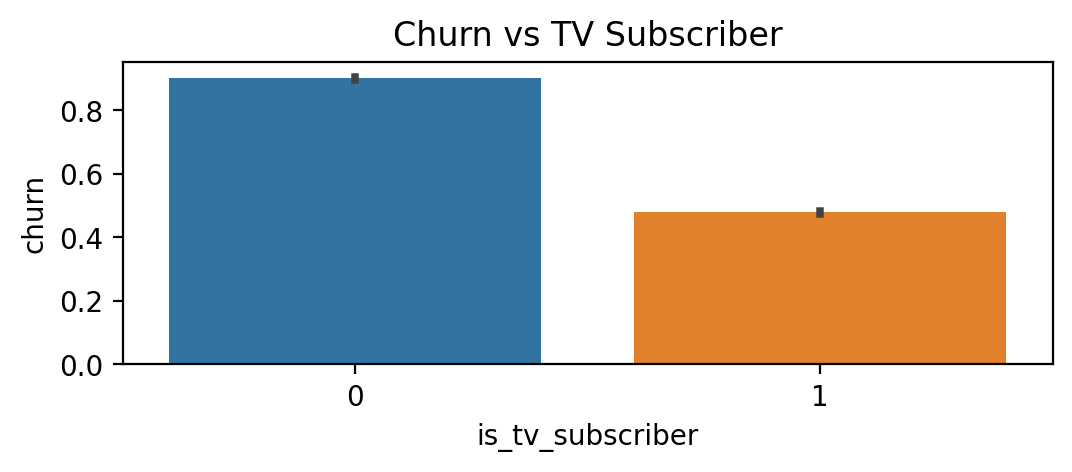

In [15]:
plt.figure(figsize=(6,2),dpi=200)
plt.title('Churn vs TV Subscriber')
sns.barplot(x=df.is_tv_subscriber,y=df.churn);

Churn rate of TV subscriber is significantly less than that of the non TV subscribers

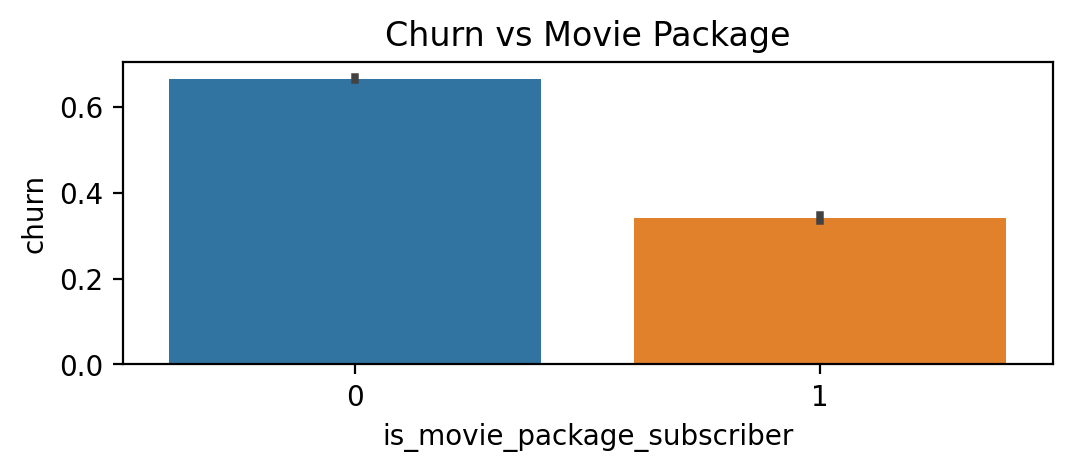

In [16]:
plt.figure(figsize=(6,2),dpi=200)
plt.title('Churn vs Movie Package')
sns.barplot(x=df.is_movie_package_subscriber,y=df.churn);

Churn rate of Movie Package subscriber is significantly less than that of the non Movie Package subscribers. Let us now check the pair plot with hue as <font color='darkgreen'><b>churn</b></font> to see patterns.

<Figure size 3000x2000 with 0 Axes>

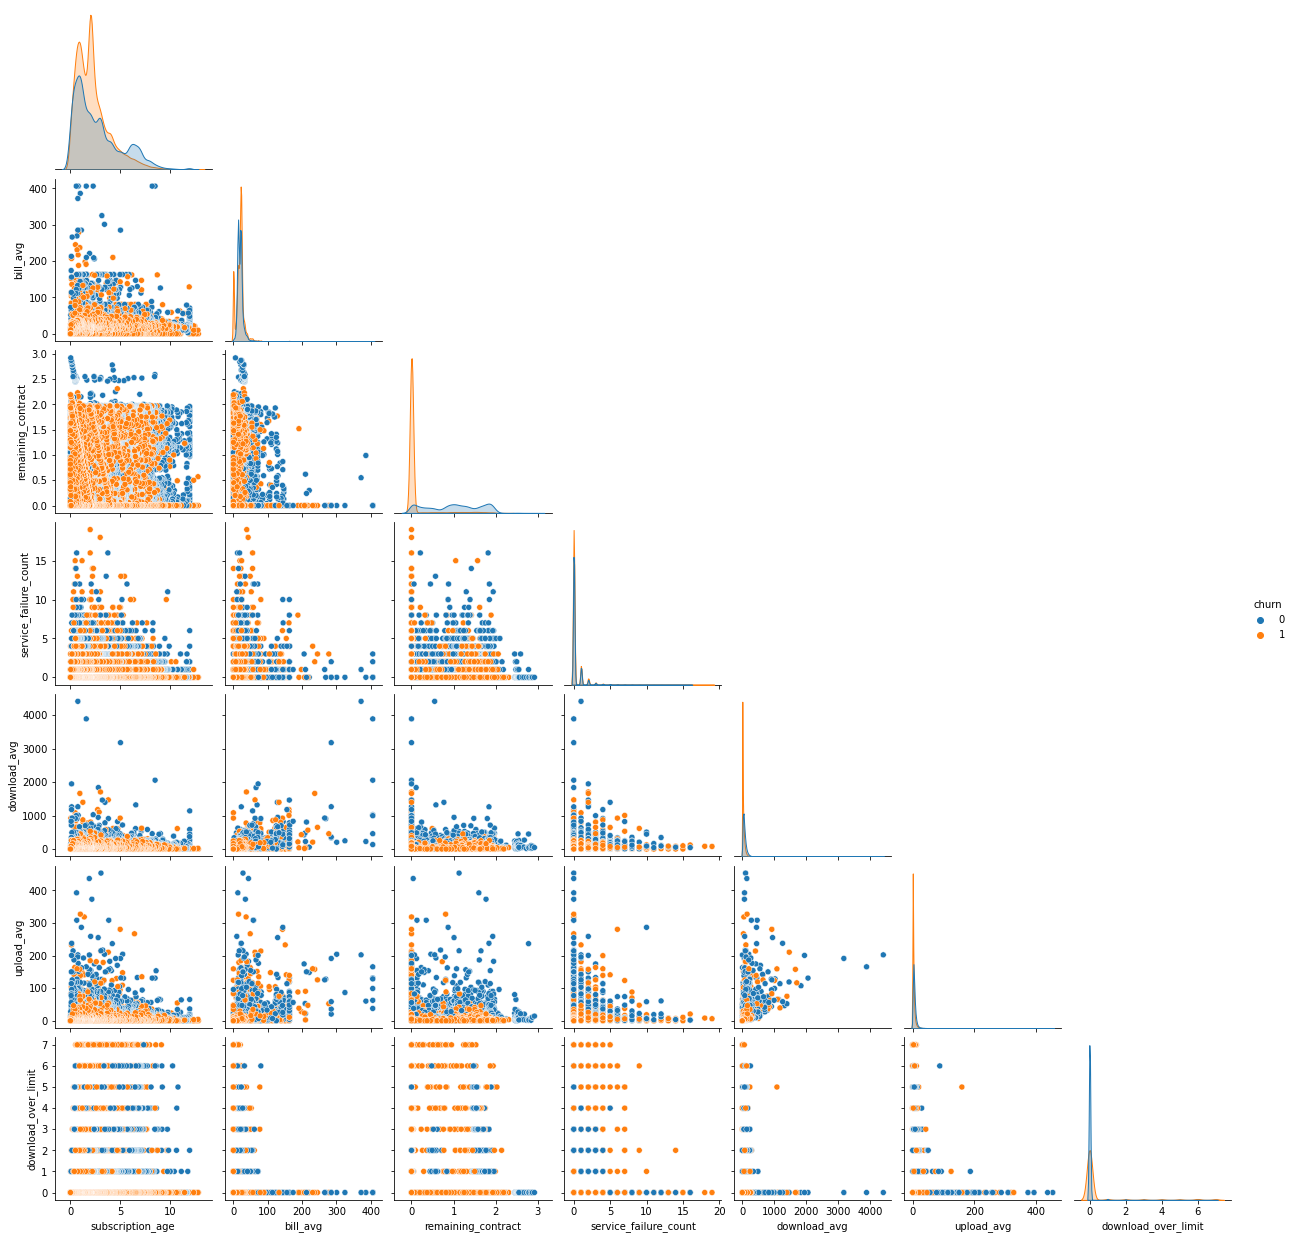

In [17]:
plt.figure(dpi=500)
sns.pairplot(df.iloc[:,2:], hue='churn', corner=True);

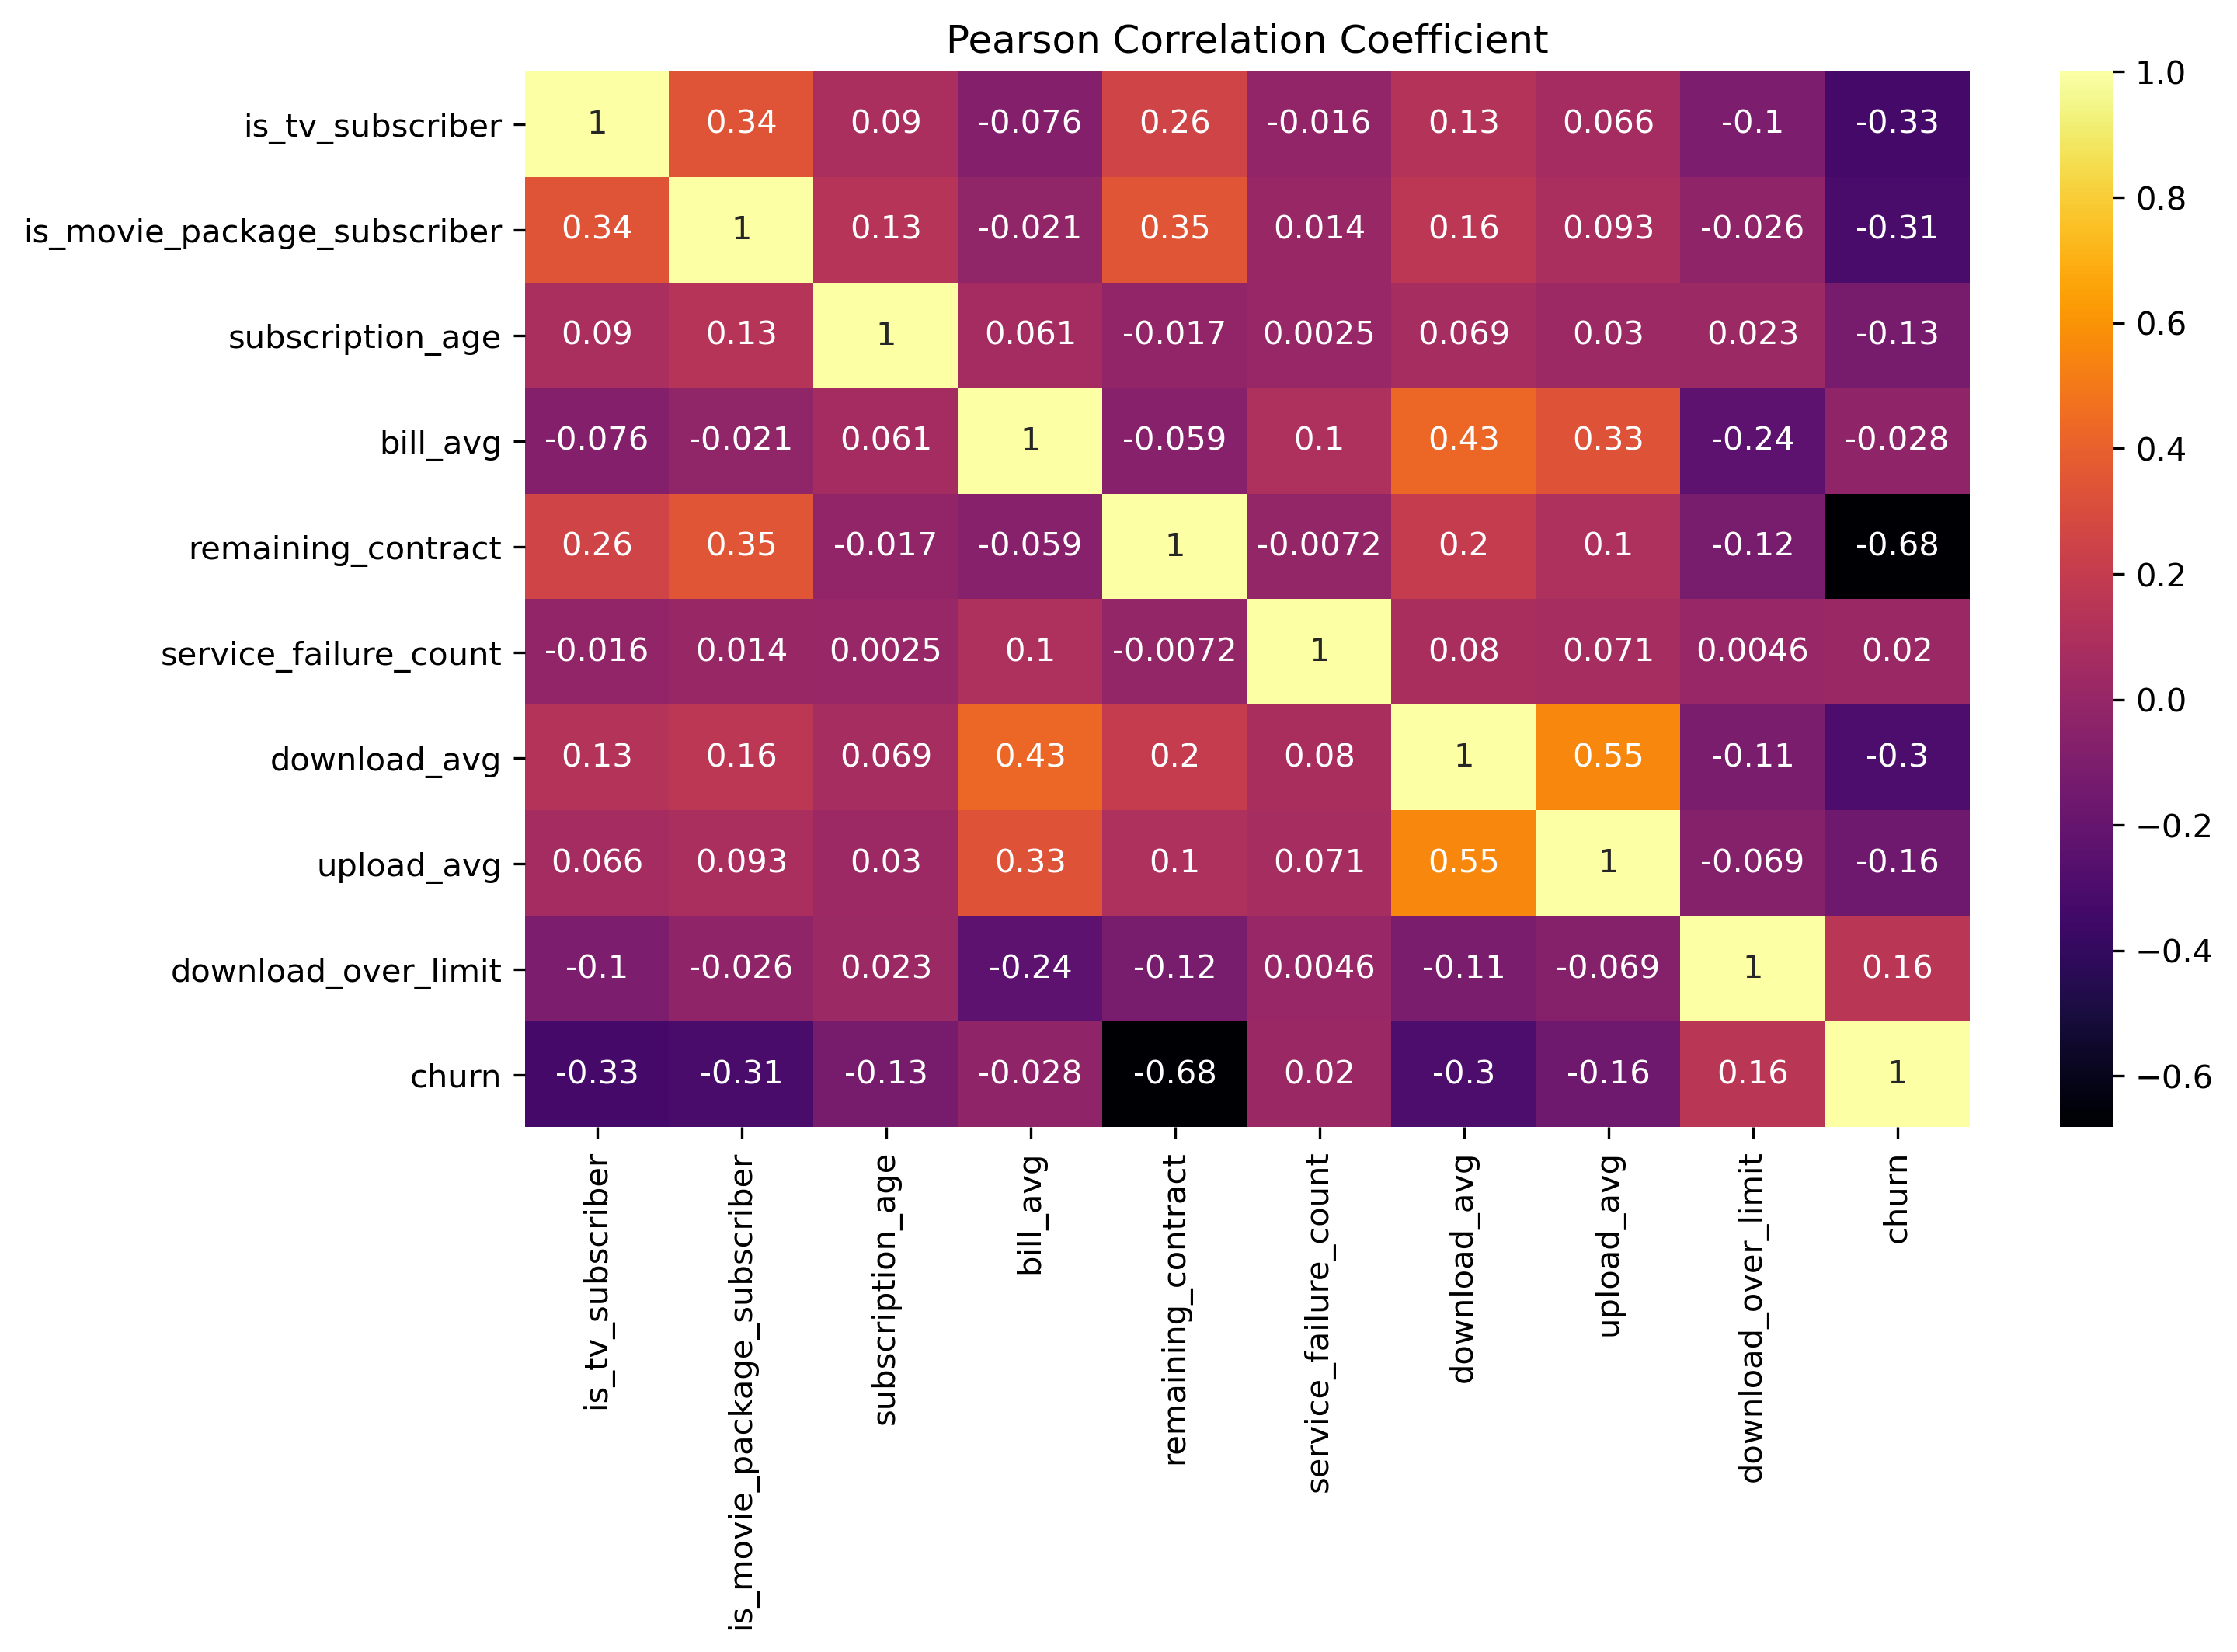

In [18]:
# heatmap to determine the correlations between the variables
plt.figure(figsize=(10,6),dpi=300)
plt.title('Pearson Correlation Coefficient')
sns.heatmap(df.corr(), annot=True, cmap='inferno');

From the above heatmap of the correlation matrix we clearly see that <font color='navy'><b>remaining_contract</b></font> is a very strong predictor of the target variable <font color='darkgreen'><b>churn</b></font> and of course other variables too have varying levels of influence on the target variable <font color='darkgreen'><b>churn</b></font>. But we do not observe any significant linear correlation among the predictor variables themselves.

# <font color='navy'><u>Data Preprocessing</u></font>

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [20]:
df_train,df_test=train_test_split(df,test_size=0.2,random_state=101)

In [21]:
#MinMaxScaling aka Normalization
normscale=MinMaxScaler()

In [22]:
# fitting only on train set and transform on both train and test set
normscale.fit(df_train)

MinMaxScaler()

In [23]:
# obtaining the normalized train set using the above MinMaxScaler
df_train_norm=pd.DataFrame(normscale.transform(df_train), columns=df.columns, index=df_train.index)

In [24]:
# obtaining the normalized test set using the above MinMaxScaler
df_test_norm=pd.DataFrame(normscale.transform(df_test), columns=df.columns, index=df_test.index)

In [25]:
# splitting both train and test set further into X and y
X_train=df_train_norm.drop(['churn'],axis=1)
y_train=df_train_norm['churn']
X_test=df_test_norm.drop(['churn'],axis=1)
y_test=df_test_norm['churn']

# <font color='navy'><u>Model Building</u></font>

# <font color='darkgreen'>Building 1st Model: lrsm1</font>
We are building our very first logistic regression model using <font color='darkgreen'><b>statsmodels.api</b></font>. Since this particular api gives us detailed statistical summary of all the variables

In [26]:
import statsmodels.api as sm

In [27]:
X_train_sm=sm.add_constant(X_train)
X_test_sm=sm.add_constant(X_test)

In [28]:
lrsm1=sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())

In [29]:
lrsm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                57513
Model:                            GLM   Df Residuals:                    57503
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19750.
Date:                Wed, 30 Mar 2022   Deviance:                       39500.
Time:                        11:45:20   Pearson chi2:                 4.66e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           4.1728      0.060     69.483      0.000       4.055       4.290
is_tv_subscriber               -1.7308      0.051    -34.158      0.000      -1.830      -1.632
is_movie_package_subscriber    -0.1025      0.028     -3.611      0.000      -0.158      -0.047
subscription_age               -3.1380      0.084    -37.295      0.000      -3.303      -2.973
bill_avg                        0.2549      0.484      0.527      0.598      -0.693       1.203
remaining_contract             -9.2020      0.084   -110.002      0.000      -9.366      -9.038
service_failure_count           2.8926      0.329      8.796      0.000       2.248       3.537
download_avg                  -50.1929      1.464    -34.278      0.000     -53.063     -47.323
upload_avg                     -0.1532      0.711     -0.215      0.829      -1.546       1.240
download_over_limit             3.1993      0.214     14.928      0.000       2.779       3.619
===============================================================================================
"""

From the above statistical summary of our model we see that the variables <font color='navy'><b>upload_avg</b></font> and <font color='navy'><b>bill_avg</b></font> have very high <b>p-value</b> which means that their corresponding coefficient values are <b>not</b> statistically significant. In a case like that we need to start eliminating variables one-by-one starting from the highest <b>p-value</b>. So let us drop <font color='navy'><b>upload_avg</b></font> variable first and rebuild our model.

In [30]:
X_train_sm.drop(['upload_avg'],axis=1,inplace=True)
X_test_sm.drop(['upload_avg'],axis=1,inplace=True)

# <font color='darkgreen'>Building 2nd Model: lrsm2</font>
We are building our second logistic regression model after dropping the variable <font color='navy'><b>upload_avg</b>

In [31]:
lrsm2=sm.GLM(y_train,X_train_sm, family=sm.families.Binomial())

In [32]:
lrsm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                57513
Model:                            GLM   Df Residuals:                    57504
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19750.
Date:                Wed, 30 Mar 2022   Deviance:                       39500.
Time:                        11:45:20   Pearson chi2:                 4.71e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           4.1733      0.060     69.556      0.000       4.056       4.291
is_tv_subscriber               -1.7308      0.051    -34.158      0.000      -1.830      -1.631
is_movie_package_subscriber    -0.1026      0.028     -3.614      0.000      -0.158      -0.047
subscription_age               -3.1376      0.084    -37.300      0.000      -3.302      -2.973
bill_avg                        0.2395      0.478      0.501      0.617      -0.698       1.177
remaining_contract             -9.2020      0.084   -110.002      0.000      -9.366      -9.038
service_failure_count           2.8919      0.329      8.794      0.000       2.247       3.536
download_avg                  -50.3278      1.324    -38.015      0.000     -52.923     -47.733
download_over_limit             3.1984      0.214     14.926      0.000       2.778       3.618
===============================================================================================
"""

From the above statistical summary of our 2nd model we see that the variable <font color='navy'><b>bill_avg</b></font> has very high <b>p-value</b> which means that its corresponding coefficient value is <b>not</b> statistically significant. So let us drop <font color='navy'><b>bill_avg</b></font> variable and rebuild our model.

In [33]:
X_train_sm.drop(['bill_avg'],axis=1,inplace=True)
X_test_sm.drop(['bill_avg'],axis=1,inplace=True)

# <font color='darkgreen'>Building 3rd Model: lrsm3</font>
We are building our third logistic regression model after dropping the variable <font color='navy'><b>bill_avg</b>

In [34]:
lrsm3=sm.GLM(y_train,X_train_sm, family=sm.families.Binomial())

In [35]:
lrsm3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                57513
Model:                            GLM   Df Residuals:                    57505
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19750.
Date:                Wed, 30 Mar 2022   Deviance:                       39500.
Time:                        11:45:20   Pearson chi2:                 4.36e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           4.1868      0.054     78.012      0.000       4.082       4.292
is_tv_subscriber               -1.7353      0.050    -34.765      0.000      -1.833      -1.637
is_movie_package_subscriber    -0.1028      0.028     -3.623      0.000      -0.158      -0.047
subscription_age               -3.1351      0.084    -37.334      0.000      -3.300      -2.971
remaining_contract             -9.2073      0.083   -110.946      0.000      -9.370      -9.045
service_failure_count           2.9024      0.328      8.844      0.000       2.259       3.546
download_avg                  -50.0800      1.228    -40.795      0.000     -52.486     -47.674
download_over_limit             3.1869      0.213     14.958      0.000       2.769       3.604
===============================================================================================
"""

Now there is no predictor variable whose <b>p-value</b> is high. Let us now check the <b>variance inflation factor (VIF)</b> to determine the presence of multicollinearity

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [37]:
VIF=pd.DataFrame()
VIF['Feature']=X_train_sm.columns
VIF['VIF']=[variance_inflation_factor(X_train_sm.values,i) for i in range(len(X_train_sm.columns))]
VIF.set_index('Feature')

,VIF
Feature,
const,7.051884
is_tv_subscriber,1.172692
is_movie_package_subscriber,1.255640
subscription_age,1.030625
remaining_contract,1.208400
service_failure_count,1.007050
download_avg,1.069844
download_over_limit,1.031102


The VIF of all the predictor variables are low. So we don't have to drop any more variables. Since we now have only few predictor variables we don't have to use automated feature selection techniques such as <b>RFE</b>. We can use these <b>7 predictor variables</b> to build our final model.

In [38]:
cols=X_train_sm.columns[1:]

Note that we were using <font color='darkgreen'><b>statsmodel.api</b></font> only for its useful and detailed statistical summary of the models. Now we're going to build our actual working models using <font color='darkgreen'><b>scikit-learn</b></font> library due to its easy of use. 

In [39]:
# we are filtering only the above 7 predictor variables
X_train_new=X_train[cols]
X_test_new=X_test[cols]

# <font color='darkgreen'>Building 4th Model: lrsk1</font>
Let us now create our fourth logistic regression model <font color='darkgreen'><b>lrsk1</b></font> using <b>sklearn library</b> and the <b>7predictor variables</b> which we obtained from our previous models

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
lrsk1=LogisticRegression()

In [42]:
lrsk1.fit(X_train_new,y_train)

LogisticRegression()

In [43]:
# this gives the probabilities of data points belonging to 'churn' class
y_train_prob=lrsk1.predict_proba(X_train_new)[:,1]

In [44]:
# using default threshold of 0.5
y_train_pred=np.array([1 if num>0.5 else 0 for num in y_train_prob])
y_train_pred

array([1, 1, 0, ..., 1, 1, 1])

Lets us now check some of the performance metrics and optimize them later

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score

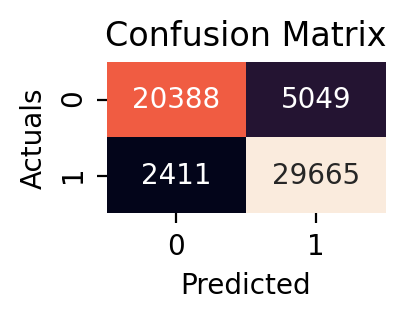

In [46]:
# determining the confusion matrix
plt.figure(figsize=(1.8,1),dpi=200)
plt.title('Confusion Matrix')
confusion=confusion_matrix(y_train,y_train_pred)
sns.heatmap(confusion, annot=True, cbar=False, fmt='.5g')
plt.xlabel('Predicted')
plt.ylabel('Actuals');

In [47]:
# TN: True Negative
TN=confusion[0,0]
# FP: False Positive
FP=confusion[0,1]
# FN: False Negative
FN=confusion[1,0]
# TP: True Positive
TP=confusion[1,1]

We're going to check some of the most important performance metrics such as <font color='darkgreen'><b>accuracy</b></font>, <font color='darkgreen'><b>sensitivity</b></font>, <font color='darkgreen'><b>specificity</b></font>, <font color='darkgreen'><b>precision</b></font>, <font color='darkgreen'><b>recall</b></font>, <font color='darkgreen'><b>roc curve</b></font> and <font color='darkgreen'><b>auc</b></font>. In this particular business problem, <font color='darkgreen'><b>sensitivity (recall)</b></font> is the most important metric. Because in simple terms, <font color='darkgreen'><b>sensitivity</b></font> is the measure of <font color='brown'>"Of all the actual positives what percentage of it our model correctly predicted as positive"</font>. Remember that <b>False Negatives</b> are costlier than <b>False Positives</b> in this problem.

In [48]:
# checking the relevant metrics
accuracy=accuracy_score(y_train,y_train_pred)
sensitivity=TP/(TP+FN) # sensitivity is also same as recall_score
specificity=TN/(TN+FP)
precision=precision_score(y_train,y_train_pred)
recall=recall_score(y_train,y_train_pred) # by definition recall=sensitivity
print(f'Accuracy={round(100*accuracy,2)}%\nSensitivity={round(100*sensitivity,2)}%\nSpecificity={round(100*specificity,2)}%\nPrecision={round(100*precision,2)}%\nRecall={round(100*recall,2)}%')

Accuracy=87.03%
Sensitivity=92.48%
Specificity=80.15%
Precision=85.46%
Recall=92.48%


# <font color='navy'><u>ROC Curve & Other Metric Curves</u></font>
The above metrics are pretty good. Particularly <font color='darkgreen'><b>sensitivity</b></font> is very good. But note that the choice of <b>probability threshold</b> value as <b>0.5</b> is quite arbitrary, let us now vary the <b>probability threshold</b> value and check if we can do better than this. Note that we're tuning the hyperparameter of <b>probability threshold</b> value only based on the training set. We didn't yet make any predictions off of the test set.

In [49]:
fpr,tpr,thresholds=roc_curve(y_train,y_train_prob,drop_intermediate=False)
auc=round(roc_auc_score(y_train,y_train_prob),2)
print(f'AUC={auc}')

AUC=0.93


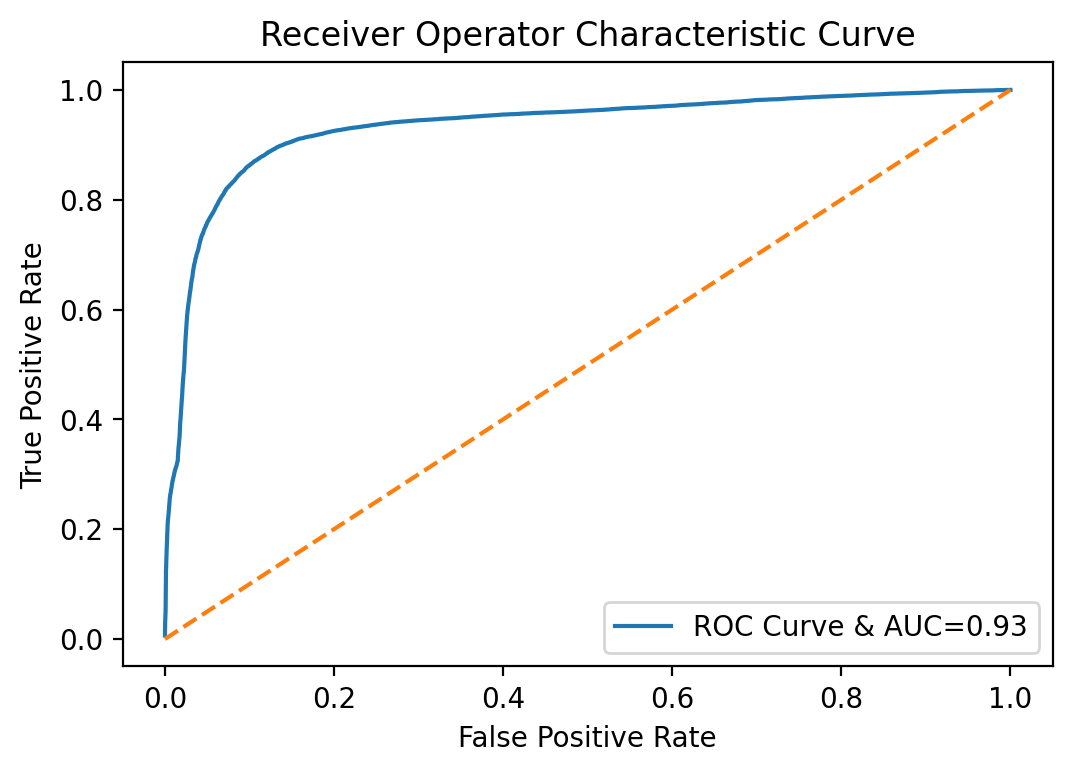

In [50]:
plt.figure(dpi=200)
plt.title('Receiver Operator Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
sns.lineplot(x=fpr,y=tpr, label='ROC Curve & AUC=0.93')
sns.lineplot(np.linspace(0,1,100),np.linspace(0,1,100), ls='--');

We know that farther the <font color='darkgreen'><b>ROC curve</b></font> is from the line <b>y=x</b> the better our model is. In that sense, we have a really good model and the <font color='darkgreen'><b>auc_score</b></font> is <b>0.93</b> which is pretty good. 

Let us now plot the graph of <font color='darkgreen'><b>accuracy</b></font> vs <font color='darkgreen'><b>threshold</b></font>, <font color='darkgreen'><b>sensitivity</b></font> vs <font color='darkgreen'><b>threshold</b></font> and <font color='darkgreen'><b>specificity</b></font> vs <font color='darkgreen'><b>threshold</b></font> on the same graph. Note that there are more than 50000 elements in <font color='darkgreen'><b>threshold</b></font> array. Hence it will take too long to compute the above metrics for all those 50000+ <font color='darkgreen'><b>threshold</b></font> values. Let us come up with a short and evenly spaced new array of <font color='darkgreen'><b>threshold</b></font> values and compute the above 3 metrics off of them.

In [51]:
# determine the threshold value for which sensitivity=specificity
thresholds[abs(tpr-(1-fpr))<0.00001]

array([0.65317206])

In [52]:
# creating 100 probability thresholds using linspace
threshold_list=np.linspace(0,1,100)
# creating lists to contain accuracy, sensitivity and specificity
accuracy_list=[]
sensitivity_list=[]
specificity_list=[]
for i in threshold_list:
    # making predictions for every choice of threshold
    y_tmp=np.array([1 if num>i else 0 for num in y_train_prob])
    # getting the confusion matrix for the above prediction
    conf=confusion_matrix(y_train,y_tmp)
    # finding the other 3 metrics using the confusion matrix
    accuracy_list.append((conf[1,1]+conf[0,0])/(conf[0,0]+conf[0,1]+conf[1,1]+conf[1,0]))
    sensitivity_list.append(conf[1,1]/(conf[1,1]+conf[1,0]))
    specificity_list.append(conf[0,0]/(conf[0,0]+conf[0,1]))

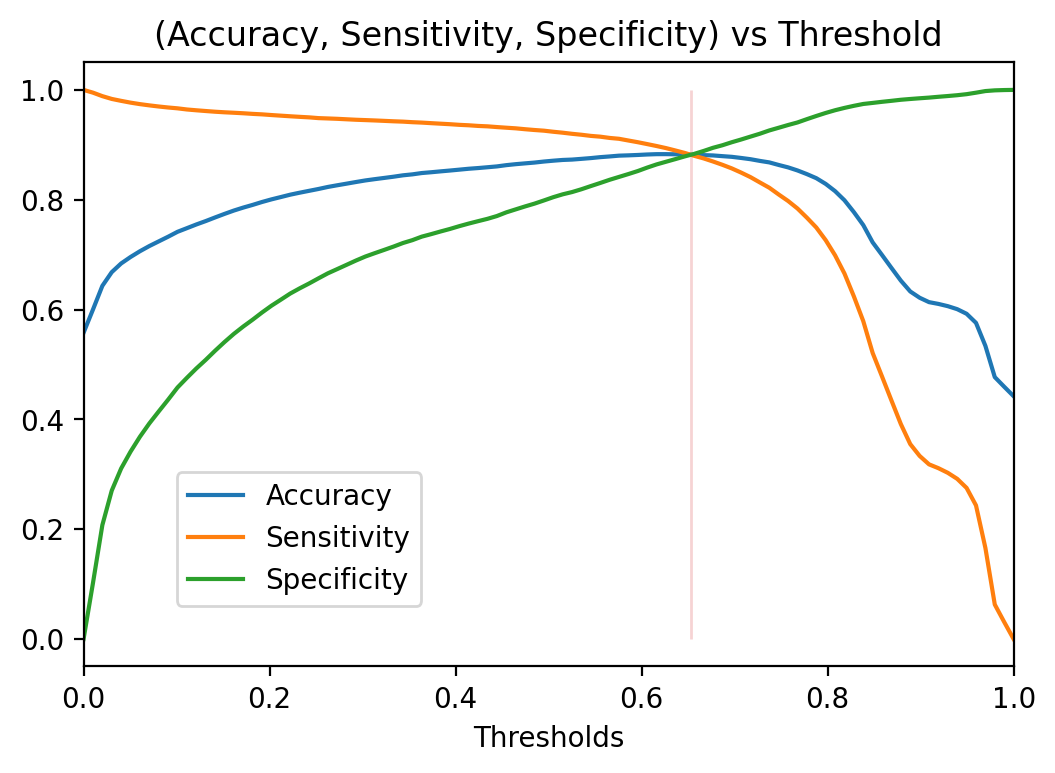

In [53]:
# plotting the curves using the metrics we've computed
plt.figure(dpi=200)
plt.title('(Accuracy, Sensitivity, Specificity) vs Threshold')
plt.xlabel('Thresholds')
plt.xlim((0,1))
sns.lineplot(x=threshold_list,y=accuracy_list, label='Accuracy')
sns.lineplot(x=threshold_list,y=sensitivity_list, label='Sensitivity')
sns.lineplot(x=threshold_list,y=specificity_list, label='Specificity')
sns.lineplot(x=0.65317206,y=[0,1])
plt.legend(loc=(0.1,0.1));

From the above graph we can see that when we set the <b>probability threshold</b> as <b>0.653</b>. We are able to simultaneously optimize for all 3 important metrics of <font color='darkgreen'><b>accuracy</b></font>, <font color='darkgreen'><b>sensitivity</b></font> and <font color='darkgreen'><b>specificity</b></font>

Let us now plot the graph of <font color='darkgreen'><b>accuracy</b></font> vs <font color='darkgreen'><b>threshold</b></font>, <font color='darkgreen'><b>precision</b></font> vs <font color='darkgreen'><b>threshold</b></font> and <font color='darkgreen'><b>recall</b></font> vs <font color='darkgreen'><b>threshold</b></font> on the same graph. 

In [54]:
# creating 100 probability thresholds using linspace
threshold_new=np.linspace(0,0.999,100)
# creating lists to contain accuracy, sensitivity and specificity
accuracy_new=[]
precision_new=[]
recall_new=[]
for i in threshold_new:
    # making predictions for every choice of threshold
    y_tmp=np.array([1 if num>i else 0 for num in y_train_prob])
    # finding the other 3 metrics
    accuracy_new.append(accuracy_score(y_train,y_tmp))
    precision_new.append(precision_score(y_train,y_tmp))
    recall_new.append(recall_score(y_train,y_tmp))

In [55]:
# determining the threshold where precision=recall
threshold_new[abs(np.array(precision_new)-np.array(recall_new))<0.005]

array([0.62563636])

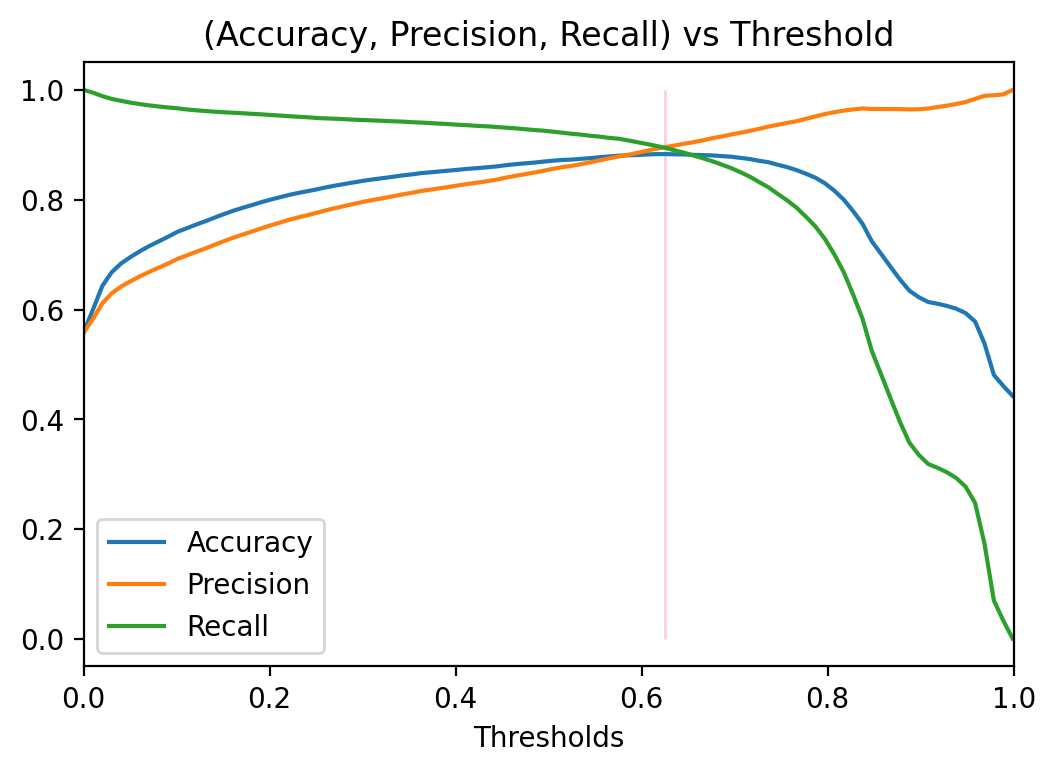

In [56]:
# plotting the curves using the metrics we've computed
plt.figure(dpi=200)
plt.title('(Accuracy, Precision, Recall) vs Threshold')
plt.xlabel('Thresholds')
plt.xlim((0,1))
sns.lineplot(x=threshold_new,y=accuracy_new, label='Accuracy')
sns.lineplot(x=threshold_new,y=precision_new, label='Precision')
sns.lineplot(x=threshold_new,y=recall_new, label='Recall')
sns.lineplot(x=0.62563636,y=[0,1]);

From the above graph we can see that when we set the <b>probability threshold</b> as <b>0.625</b>. We are able to simultaneously optimize both <font color='darkgreen'><b>precision</b></font> and <font color='darkgreen'><b>recall</b></font>. Even <font color='darkgreen'><b>accuracy</b></font> value is quite close to the above 2 metrics.

Let us fix <b>0.625</b> as our final probability threshold and make predictions off of the test set and check its performance using the above metrics.

In [57]:
# predicting the probabilities for data points in the test set
y_test_prob=lrsk1.predict_proba(X_test_new)[:,1]
y_test_prob

array([0.01583903, 0.1213496 , 0.86442339, ..., 0.24309577, 0.84478185,
       0.84908606])

In [58]:
# making classification using 0.625 as threshold
y_train_pred=np.array([1 if prob>0.625 else 0 for prob in y_train_prob])
y_test_pred=np.array([1 if prob>0.625 else 0 for prob in y_test_prob])

# <font color='navy'><u>Classification Performance Metrics</u></font>
Though we've already computed all the important metrics such as <font color='darkgreen'><b>accuracy</b></font>, <font color='darkgreen'><b>sensitivity</b></font>, <font color='darkgreen'><b>specificity</b></font>, <font color='darkgreen'><b>precision</b></font> and <font color='darkgreen'><b>recall</b></font> etc. We've computed them based on an arbitrarily chosen <b>probability threshold</b> value of <b>0.5</b>. Later on using <font color='darkgreen'><b>ROC curve</b></font> and other <font color='darkgreen'><b>metric curves</b></font>, we've decided to choose <b>probability threshold</b> of <b>0.625</b> to optimize and find a balance between various metrics. Now we need to re-compute all the above metrics for both <b>train set</b> and <b>test set</b> using the new value <b>0.625</b> to figure out if our model is generalizing well.

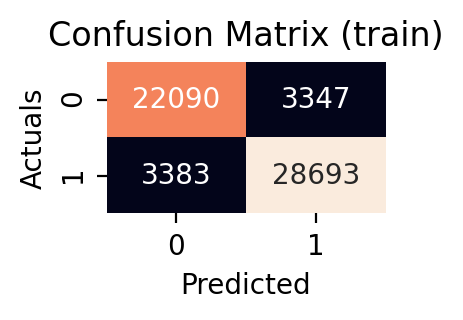

In [59]:
# determining the confusion matrix for train set
plt.figure(figsize=(1.8,1),dpi=200)
plt.title('Confusion Matrix (train)')
confusion_train=confusion_matrix(y_train,y_train_pred)
sns.heatmap(confusion_train, annot=True, cbar=False, fmt='.5g')
plt.xlabel('Predicted')
plt.ylabel('Actuals');

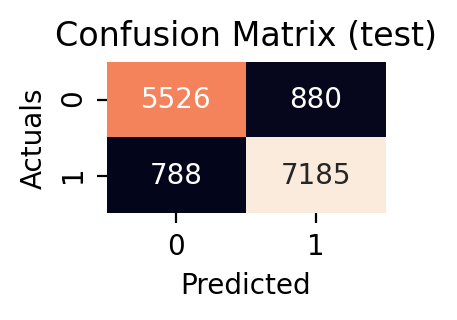

In [60]:
# determining the confusion matrix for test set
plt.figure(figsize=(1.8,1),dpi=200)
plt.title('Confusion Matrix (test)')
confusion_test=confusion_matrix(y_test,y_test_pred)
sns.heatmap(confusion_test, annot=True, cbar=False, fmt='.5g')
plt.xlabel('Predicted')
plt.ylabel('Actuals');

In [61]:
# TN: True Negative
TN_train=confusion_train[0,0]

# FP: False Positive
FP_train=confusion_train[0,1]

# FN: False Negative
FN_train=confusion_train[1,0]

# TP: True Positive
TP_train=confusion_train[1,1]

In [62]:
# TN: True Negative
TN_test=confusion_test[0,0]

# FP: False Positive
FP_test=confusion_test[0,1]

# FN: False Negative
FN_test=confusion_test[1,0]

# TP: True Positive
TP_test=confusion_test[1,1]

We're going to check some of the most important performance metrics such as <font color='darkgreen'><b>accuracy</b></font>, <font color='darkgreen'><b>sensitivity</b></font>, <font color='darkgreen'><b>specificity</b></font>, <font color='darkgreen'><b>precision</b></font> and <font color='darkgreen'><b>recall</b></font> for both the <b>train</b> and <b>test</b> set.

In [63]:
# checking the metrics for the train set
accuracy_train=accuracy_score(y_train,y_train_pred)
sensitivity_train=TP_train/(TP_train+FN_train) 
specificity_train=TN_train/(TN_train+FP_train)
precision_train=precision_score(y_train,y_train_pred)
recall_train=recall_score(y_train,y_train_pred) # by definition recall=sensitivity

# checking the metrics for the test set
accuracy_test=accuracy_score(y_test,y_test_pred)
sensitivity_test=TP_test/(TP_test+FN_test) 
specificity_test=TN_test/(TN_test+FP_test)
precision_test=precision_score(y_test,y_test_pred)
recall_test=recall_score(y_test,y_test_pred) # by definition recall=sensitivity

# representing all the above metrics in a dataframe
metrics=pd.DataFrame()
metrics['metrics']=['Accuracy','Sensitivity','Specificity','Precision','Recall']
metrics['train %']=np.round(100*np.array([accuracy_train,sensitivity_train,specificity_train,precision_train,recall_train]),2)
metrics['test %']=np.round(100*np.array([accuracy_test,sensitivity_test,specificity_test,precision_test,recall_test]),2)

metrics.set_index('metrics')

,train %,test %
metrics,,
Accuracy,88.30,88.40
Sensitivity,89.45,90.12
Specificity,86.84,86.26
Precision,89.55,89.09
Recall,89.45,90.12


Here we can clearly see that all the metrics of the <b>test set</b> are very close to that of the <b>train set</b> which means that our <b>binary classification logistic regression model</b> <font color='darkgreen'><b>lrsk1</b></font> is generalizing well to the unseen data. 

# <font color='darkgreen'><b>Building Final Model: final_model</b></font>
Let us use <font color='darkgreen'><b>lrsk1</b></font> to build our <font color='darkgreen'><b>final_model</b></font> where we take full advantage of the entire data set by combining training and testing set into one data set.

In [64]:
X=pd.concat([X_train_new,X_test_new],axis=0, ignore_index=True)
y=pd.concat([y_train,y_test], axis=0, ignore_index=True)

In [65]:
final_model=LogisticRegression()

In [66]:
# fitting the entire data on the above logistic regression object
final_model.fit(X,y)

LogisticRegression()

In [67]:
# predicting probabilities for the entire data set using the above model
y_hat_prob=final_model.predict_proba(X)[:,1]

In [68]:
# predicting classes using the above probabilities using 0.625 as threshold
y_hat_pred=np.array([1 if prob>0.625 else 0 for prob in y_hat_prob])

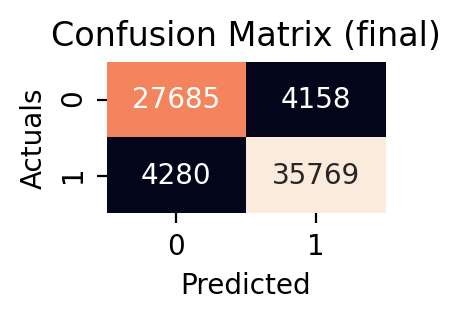

In [69]:
# determining the confusion matrix
plt.figure(figsize=(1.8,1),dpi=200)
plt.title('Confusion Matrix (final)')
confusion_final=confusion_matrix(y,y_hat_pred)
sns.heatmap(confusion_final, annot=True, cbar=False, fmt='.5g')
plt.xlabel('Predicted')
plt.ylabel('Actuals');

In [70]:
# TN: True Negative
TN_final=confusion_final[0,0]

# FP: False Positive
FP_final=confusion_final[0,1]

# FN: False Negative
FN_final=confusion_final[1,0]

# TP: True Positive
TP_final=confusion_final[1,1]

Computing all the important metrics such as <font color='darkgreen'><b>accuracy</b></font>, <font color='darkgreen'><b>sensitivity</b></font>, <font color='darkgreen'><b>specificity</b></font>, <font color='darkgreen'><b>precision</b></font> and <font color='darkgreen'><b>recall</b></font> for this <font color='darkgreen'><b>final_model</b></font>.

In [71]:
# checking the metrics for the final_model
accuracy_final=accuracy_score(y,y_hat_pred)
sensitivity_final=TP_final/(TP_final+FN_final) 
specificity_final=TN_final/(TN_final+FP_final)
precision_final=precision_score(y,y_hat_pred)
recall_final=recall_score(y,y_hat_pred) # by definition recall=sensitivity

# representing all the above metrics in a dataframe
final_metrics=pd.DataFrame()
final_metrics['metrics']=['Accuracy','Sensitivity','Specificity','Precision','Recall']
final_metrics['final_model']=np.round(100*np.array([accuracy_final,sensitivity_final,specificity_final,precision_final,recall_final]),2)

final_metrics.set_index('metrics')

,final_model
metrics,
Accuracy,88.26
Sensitivity,89.31
Specificity,86.94
Precision,89.59
Recall,89.31


# <font color='darkred'><b>final_model Model Performance:</b></font>

<font color='darkred'><b>Accuracy: 88.26%</b></font><br/>
Our predictions are correct <b>88.26%</b> of the times

<font color='darkred'><b>Sensitivity: 89.31%</b></font><br/>
Of all the <b>actual positives</b> our model captured <b>89.31%</b> of them

<font color='darkred'><b>Specificity: 86.94%</b></font><br/>
Of all the <b>actual negatives</b> our model captured <b>86.94%</b> of them

<font color='darkred'><b>Precision: 89.59%</b></font><br/>
Of all the <b>predicted positives</b> our model is correct <b>89.59%</b> of the times

<font color='darkred'><b>Recall: 89.31%</b></font><br/>
Same definition as <b>sensitivity</b>

# <font color='navy'><u>Coefficients of Variables & Odds-Ratio:</u></font>

In [72]:
stats=pd.DataFrame()
stats['features']=['const']+list(X.columns)
stats['coeff']=[final_model.intercept_[0]]+list(final_model.coef_[0])
stats['odds_ratio']=np.exp(np.array(stats['coeff']))
stats

,features,coeff,odds_ratio
0,const,3.942998,5.157298e+01
1,is_tv_subscriber,-1.714700,1.800176e-01
2,is_movie_package_subscriber,-0.140856,8.686144e-01
3,subscription_age,-3.218820,4.000223e-02
4,remaining_contract,-9.259380,9.521436e-05
5,service_failure_count,1.922891,6.840707e+00
6,download_avg,-24.926360,1.494925e-11
7,download_over_limit,3.323349,2.775315e+01


From the above table, we can see that <font color='darkgreen'><b>download_avg</b></font> has the greatest negative influence on <font color='darkgreen'><b>churn</b></font> which means that higher the <font color='darkgreen'><b>download_avg</b></font> lower the odds of <font color='darkgreen'><b>churn</b></font> and <font color='darkgreen'><b>remaining_contract</b></font> has the second highest negative influence on <font color='darkgreen'><b>churn</b></font>. Likewise <font color='darkgreen'><b>download_over_limit</b></font> has the greatest positive influence on <font color='darkgreen'><b>churn</b></font> which means that higher the <font color='darkgreen'><b>download_over_limit</b></font> higher the odds of <font color='darkgreen'><b>churn</b></font> and <font color='darkgreen'><b>service_failure_count</b></font> has the second highest positive influence on <font color='darkgreen'><b>churn</b></font>